In [83]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import json
import sys

sys.path.append(str(Path.cwd().parent / 'scripts'))

from _helpers import to_date_period, to_datetime

In [110]:
plot_style = {
    "nodal": "agg",
    "eso": "agg",
    "fti": "all",
    "national": "all",
}
agg_method = {
    "wholesale_price": "mean",
}

quants = ["wholesale_price", "load", "post_balancing_price"]

root = Path.cwd().parent / 'results' / 'periods'

start = pd.Timestamp('2023-05-01')
end = pd.Timestamp('2023-05-03')

considered_data = {layout: {} for layout in plot_style.keys()}

def is_in_frame(ts):
    return ts >= start and ts <= end

found_timesteps = []

for file in os.listdir(root):

    # ts = pd.Timestamp(file.split('.')[0])
    ts = to_datetime(*(file.split('.')[0].split('_')))

    # print("found datetime")
    # print(ts)
    
    if not is_in_frame(ts):
        continue

    with open(root / file) as f:
        data = json.load(f)

    for ts in data.keys():
        # ts = pd.Timestamp.from_timest(ts)

        ts = pd.to_datetime(int(ts), unit='s')
        ts_sec = str(int(ts.timestamp()))

        if not is_in_frame(ts):
            continue

        found_timesteps.append(ts)
    
        for layout in plot_style.keys():
            
            regions = data[ts_sec][layout]["geographies"].keys()

            considered_data[layout][ts] = {}

            for region in regions:
                considered_data[layout][ts][region] = {}

                for quant in quants:
                    considered_data[layout][ts][region][quant] = data[ts_sec][layout]["geographies"][region]["variables"][quant]

                # considered_data[layout][ts][region][quant].append(
                #     data[ts_sec][layout]["geographies"][region]["variables"][quant])

            # considered_data[layout][ts] = data[ts]['nodal']

# found_timesteps
# considered_data

In [111]:
def get_flowconstraints(daterange):

    prices = pd.DataFrame({'daterange':daterange})
    filename = Path.cwd().parent / 'resources' / 'live_data'
    template = '{}_{}'
    
    def get_constraint(ts):
        date, period = to_date_period(ts)
        return (
            pd.read_csv(filename / template.format(date, period) / 'constraint_flows.csv', index_col=0)
            [['limit']]
            .rename(columns={'limit': ts})
        )
    contraints = list()
    for dt in daterange:
        contraints.append(get_constraint(dt))

    # prices['price'] = prices['daterange'].apply(get_price)

    return pd.concat(contraints, axis=1).T


# flow_constraints = get_flowconstraints(found_timesteps)

In [112]:
def get_real_prices(daterange):

    filename = Path.cwd().parent / 'data' / 'market_index_winter.csv'
    prices = pd.read_csv(filename, index_col=0, parse_dates=True)

    # def get_price(ts):
    # date, period = to_date_period(ts)
    #     return pd.read_csv(filename / template.format(date, period) / 'price_stats.csv', index_col=0).loc["market_index"]
    # prices['price'] = prices['daterange'].apply(get_price)
    # return prices.set_index('daterange')['price']

    _, ax = plt.subplots(1, 1, figsize=(16, 4))
    ax.plot(prices.sort_index().loc[pd.Timestamp('2024-03-01'):pd.Timestamp('2024-03-30')], label='market_index')
    plt.show()

    return prices.loc[daterange]

# real_prices = get_real_prices(found_timesteps)


In [113]:
'''
quant = 'marginal_price'

fig, axs = plt.subplots(len(plot_style) + 1, 1, figsize=(12, 3*(len(plot_style) + 1)))

for i, layout in enumerate(plot_style.keys()):

    regions = list((c := considered_data[layout])[list(c)[0]].keys())
    df = pd.DataFrame(columns=regions, index=found_timesteps)

    for region in regions:
        df[region] = [considered_data[layout][ts][region][quant] for ts in found_timesteps]

    ax = axs[i]
    df = df.sort_index()

    if plot_style[layout] == "agg":
        ax.plot(
            getattr(df, agg_method.get(quant, "sum"))(axis=1), label="modelled mean")

        for col in df.columns:
            ax.plot(df[col], linestyle='--', linewidth=0.5, alpha=0.5, color='grey')

    else:
        for col in df.columns:
            ax.plot(df[col], label=col, linestyle='-', linewidth=1.5,)
    # ax.plot(real_prices, label="real wholesale price", linewidth=1.5, color='darkred')

    ax.set_ylabel('Price [£/MWh]')

for border in flow_constraints.columns:
    axs[-1].plot(flow_constraints[border].mul(1e-3), label=border)
    axs[-1].set_ylabel('Max Flow [GW]')

for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

plt.show()
'''

pass

In [114]:
quant = 'post_balancing_price'
# quant = 'wholesale_price'

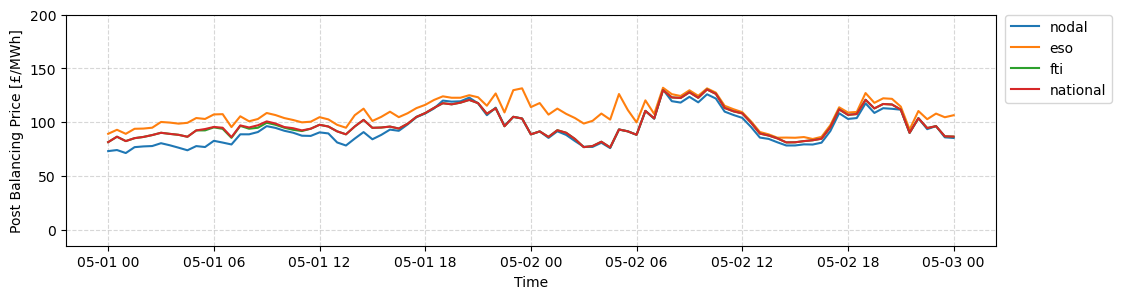

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1, figsize=(12, 3))

for i, layout in enumerate(plot_style.keys()):

    regions = list((c := considered_data[layout])[list(c)[0]].keys())
    marginal_prices = pd.DataFrame(columns=regions, index=found_timesteps)
    loads = pd.DataFrame(columns=regions, index=found_timesteps)

    for region in regions:
        marginal_prices[region] = [considered_data[layout][ts][region][quant] for ts in found_timesteps]
        loads[region] = [considered_data[layout][ts][region]["load"] for ts in found_timesteps]

    weights = loads.T.div(loads.sum(axis=1)).iloc[:,0].rename('load_weights')
    total_price = marginal_prices.mul(weights).sum(axis=1)

    # print('total price')
    # print(total_price)
    total_price = total_price.sort_index()

    # if plot_style[layout] == "agg":
    ax.plot(total_price, label=layout)

# ax.plot(real_prices.sort_index(), label="real")

ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

nice_names = {
    "wholesale_price": "Wholesale Price [£/MWh]",
    "post_balancing_price": "Post Balancing Price [£/MWh]"
}

ax.set_ylabel(nice_names[quant])
ax.set_xlabel('Time')

ax.set_ylim(-15, 200)

plt.show()

KeyError: 'marginal_price'

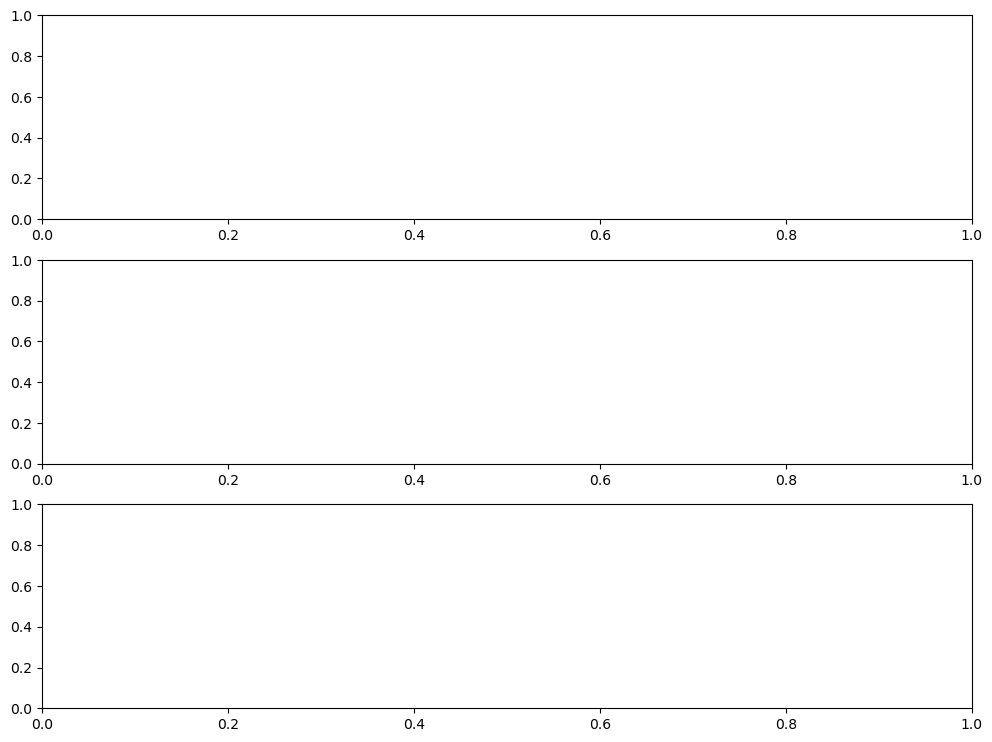

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

extreme_times = dict()

plot_layouts = ['nodal', 'eso', 'fti']

fig, axs = plt.subplots(len(plot_style)-1, 1, figsize=(12, 3*(len(plot_style)-1)))

# compute marginal price in national layout for reference
regions = list((c := considered_data["national"])[list(c)[0]].keys())
marginal_prices = pd.DataFrame(columns=regions, index=found_timesteps)
loads = pd.DataFrame(columns=regions, index=found_timesteps)

for region in regions:
    marginal_prices[region] = [considered_data["national"][ts][region]["marginal_price"] for ts in found_timesteps]
    loads[region] = [considered_data["national"][ts][region]["load"] for ts in found_timesteps]

weights = loads.T.div(loads.sum(axis=1)).iloc[:,0].rename('load_weights')
national_price = marginal_prices.mul(weights).sum(axis=1).sort_index()

extreme_n = 3

for i, layout in enumerate(plot_layouts):

    if layout == 'national':
        continue

    ax = axs[i]

    regions = list((c := considered_data[layout])[list(c)[0]].keys())
    marginal_prices = pd.DataFrame(columns=regions, index=found_timesteps)
    loads = pd.DataFrame(columns=regions, index=found_timesteps)

    for region in regions:
        marginal_prices[region] = [considered_data[layout][ts][region]["marginal_price"] for ts in found_timesteps]
        loads[region] = [considered_data[layout][ts][region]["load"] for ts in found_timesteps]

    weights = loads.T.div(loads.sum(axis=1)).iloc[:,0].rename('load_weights')
    
    marginal_prices = marginal_prices.sort_index()
    total_price = marginal_prices.mul(weights).sum(axis=1)

    totals = marginal_prices.sum().sort_values(ascending=False).index
    worst = totals[:extreme_n]
    best = totals[-extreme_n:]

    method = 'capitalize' if len(layout) > 3 else 'upper'
    ax.plot(total_price, color='green', label=None)# label=f"{getattr(layout, method)()} Regions", color='green')
    ax.plot(national_price, color='purple', label=None)#, label="National Market")

    ax.set_ylabel('Price [£/MWh]')

    extreme_kwargs = dict(linestyle='--', linewidth=1, alpha=0.5)

    labels = [f"{getattr(layout, method)()} Regions", "National Market"]
    handles = [
        plt.Line2D([0], [0], color='g'), plt.Line2D([0], [0], color='green'),
        plt.Line2D([0], [0], color='g'), plt.Line2D([0], [0], color='purple'),
    ]

    labels.append('Highest Prices')
    handles.append(plt.Line2D([0], [0], color='r', **extreme_kwargs))

    marginal_prices[worst].plot(ax=ax, **extreme_kwargs)

    labels.append('Lowest Prices')
    handles.append(plt.Line2D([0], [0], color='b', **extreme_kwargs))

    marginal_prices[best].plot(ax=ax, color='blue', **extreme_kwargs)

    diff = total_price - national_price
    worst_period = diff.idxmax()
    best_period = diff.idxmin()

    ax.axvline(worst_period, color='orange', linestyle='--', linewidth=0.8)
    labels.append('Worst Period')    
    handles.append(plt.Line2D([0], [0], color='orange', linestyle='--', linewidth=0.8))

    ax.axvline(best_period, color='brown', linestyle='--', linewidth=0.8)
    labels.append('Best Period')
    handles.append(plt.Line2D([0], [0], color='brown', linestyle='--', linewidth=0.8))

    worst_day = diff.resample('d').mean().idxmax()
    best_day = diff.resample('d').mean().idxmin()

    ax.axvline(worst_day, color='orange', linestyle=':', linewidth=1.2)
    labels.append('Worst Day')    
    handles.append(plt.Line2D([0], [0], color='orange', linestyle=':', linewidth=1.2))

    ax.axvline(best_day, color='brown', linestyle=':', linewidth=1.2)
    labels.append('Best Day')
    handles.append(plt.Line2D([0], [0], color='brown', linestyle=':', linewidth=1.2))
    ax.legend(handles[2:], labels, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

    inner = {}
    for quant in ['best_period', 'worst_period', 'best_day', 'worst_day']:
        inner[quant] = globals()[quant]
    extreme_times[layout] = inner

for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.5)

    ax.set_ylim(-5, 125)
    ax.set_ylabel('Price [£/MWh]')
    ax.set_xlim(start, end)

for ax in axs[:-1]: ax.set_xticklabels([])

axs[-1].set_xlabel('Time')

plt.tight_layout()
plt.show()

In [83]:
extreme_times

{'nodal': {'best_period': Timestamp('2024-03-08 18:30:00'),
  'worst_period': Timestamp('2024-03-09 11:00:00'),
  'best_day': Timestamp('2024-03-08 00:00:00'),
  'worst_day': Timestamp('2024-03-14 00:00:00')},
 'eso': {'best_period': Timestamp('2024-03-08 18:30:00'),
  'worst_period': Timestamp('2024-03-10 11:00:00'),
  'best_day': Timestamp('2024-03-08 00:00:00'),
  'worst_day': Timestamp('2024-03-10 00:00:00')},
 'fti': {'best_period': Timestamp('2024-03-08 18:30:00'),
  'worst_period': Timestamp('2024-03-09 11:00:00'),
  'best_day': Timestamp('2024-03-08 00:00:00'),
  'worst_day': Timestamp('2024-03-14 00:00:00')}}

In [77]:
balance = pd.read_csv(Path.cwd().parent / 'resources' / 'live_data' / '2024-03-06_8' / 'real_balancing_actions.csv', index_col=0)
print(balance)

offers = balance.loc[balance['offer volume'] > 0]

offer_rev = balance['offer revenue'].sum()
print(offer_rev)

bid_rev = balance['bid revenue'].sum()
print(bid_rev)

         offer volume  offer price  bid volume  bid price  offer revenue  \
SGRWO-2           0.0       1500.0   12.016667      100.0            0.0   
SGRWO-3           0.0       1500.0   25.025000      100.0            0.0   
SGRWO-4           0.0       1500.0   24.033333      100.0            0.0   
FOYE-1            0.0         85.0   77.500000       50.0            0.0   
MOWEO-3           0.0       9999.0   91.000000     9999.0            0.0   
FASN2             0.0         80.0    7.000000       70.0            0.0   
FASN3             0.0         80.0    6.000000       70.0            0.0   
FASN-1            0.0         80.0    7.000000       70.0            0.0   
SEAB-2          120.0        149.0    0.000000       30.0        17880.0   
SGRWO-5           0.0       1500.0   13.516667      100.0            0.0   
JAMBB-1           0.0       9999.0    1.416667     9999.0            0.0   
GORDW-2           0.0        500.0   16.016667      100.0            0.0   
PEHE-1      

In [88]:
# a = pn.reset_index()
a.loc[a.NationalGridBmUnit.str.contains("FASN")]

,NationalGridBmUnit,PN,MELS
562,FASN3,19.0,19
563,FASN-4,8.0,8
1577,FASN-1,21.0,21
1578,FASN2,21.0,21


In [89]:
import os
os.listdir(Path.cwd().parent / 'resources')

estcost = pd.read_csv(Path.cwd().parent / 'resources' / 'bmu_cost_estimates.csv', index_col=0).rename(columns={'0': 'cost_estimate'})
pn = pd.read_csv(Path.cwd().parent / 'resources' / 'live_data' / '2024-03-06_8' / 'elexon_bmus.csv', index_col=0)

unit = 'FASN3'
# print(estcost.loc[unit])

print(pn.loc[unit])

PN      19.0
MELS    19.0
Name: FASN3, dtype: float64


In [90]:
550 / 19

28.94736842105263

In [106]:
base = Path.cwd().parent / 'resources' / 'live_data'

for file in os.listdir(base):

    if 'regions_onshore_s.geojson' in os.listdir(base / file):
        os.remove(base / file / 'regions_onshore_s.geojson')

    if 'maps.pdf' in os.listdir(base / file):
        os.remove(base / file / 'maps.pdf')

In [8]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path

sys.path.append(str(Path.cwd().parent / 'scripts'))

from _helpers import to_date_period, to_datetime

In [9]:
to_datetime("2024-04-02", 1)

Timestamp('2024-04-02 01:00:00')

In [18]:
from io import StringIO
import requests

url = "https://data.elexon.co.uk/bmrs/api/v1/demand/actual/total?from=2024-03-06&to=2024-03-07&settlementPeriodFrom=1&settlementPeriodTo=48&format=csv"

response = requests.get(url)
data = pd.read_csv(StringIO(response.content.decode('utf-8')))
data

,PublishTime,StartTime,SettlementDate,SettlementPeriod,Quantity
0,2024-03-08T00:25:09Z,2024-03-07T23:30:00Z,2024-03-07,48,31350.0
1,2024-03-07T23:55:08Z,2024-03-07T23:00:00Z,2024-03-07,47,32633.0
2,2024-03-07T23:25:08Z,2024-03-07T22:30:00Z,2024-03-07,46,34744.0
3,2024-03-07T22:55:09Z,2024-03-07T22:00:00Z,2024-03-07,45,36621.0
4,2024-03-07T22:25:09Z,2024-03-07T21:30:00Z,2024-03-07,44,40442.0
...,...,...,...,...,...
91,2024-03-06T02:55:09Z,2024-03-06T02:00:00Z,2024-03-06,5,30087.0
92,2024-03-06T02:25:08Z,2024-03-06T01:30:00Z,2024-03-06,4,31309.0
93,2024-03-06T01:55:09Z,2024-03-06T01:00:00Z,2024-03-06,3,32117.0
94,2024-03-06T01:25:09Z,2024-03-06T00:30:00Z,2024-03-06,2,32685.0


In [20]:
to_datetime("2024-03-06", 1)

Timestamp('2024-03-06 01:00:00')

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent / 'scripts'))

from _helpers import to_date_period, to_datetime

In [18]:
td = to_datetime("2024-03-06", 48)
td

Timestamp('2024-03-06 23:30:00')

In [19]:
import pandas as pd

def to_date_period(dt):

    period = (dt - dt.normalize()) // pd.Timedelta(minutes=30) + 1
    if period <= 0:
        date = (dt - pd.Timedelta(days=1)).strftime('%Y-%m-%d')
        period = 48 + period
    else:
        date = dt.strftime('%Y-%m-%d')

    return date, period

In [20]:
to_date_period(td)

('2024-03-06', 48)

In [233]:
import os
import pypsa
from pathlib import Path

In [234]:
root = Path.cwd().parent / 'resources' / 'live_data' / '2024-03-16_12'

In [235]:
n = pypsa.Network(root / 'network_s_nodal_solved.nc')
n

INFO:pypsa.io:Imported network network_s_nodal_solved.nc has buses, carriers, generators, lines, links, loads


PyPSA Network 'PyPSA-Eur'
Components:
 - Bus: 284
 - Carrier: 2
 - Generator: 259
 - Line: 414
 - Link: 2
 - Load: 284
Snapshots: 1

(<matplotlib.collections.PatchCollection at 0x1c714173520>,
 <matplotlib.collections.LineCollection at 0x1c71401e9e0>)

c:\Users\lukas\miniforge3\envs\pypsa-eur\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


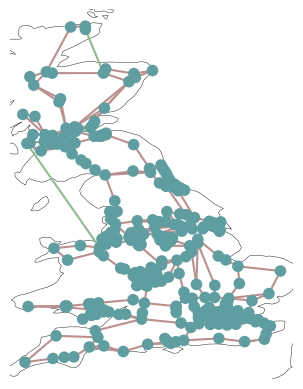

In [236]:
n.plot()

In [30]:
import pandas as pd

now = pd.Timestamp.now()
print(now)
# now = pd.Timestamp('2024-02-05 00:31:00')

day = now.strftime('%Y-%m-%d')
print(now)

now.hour * 2 + now.minute // 30

2024-05-04 18:05:58.022933
2024-05-04 18:05:58.022933


36

In [32]:
now.strftime('%Y-%m-%d')

'2024-05-04'

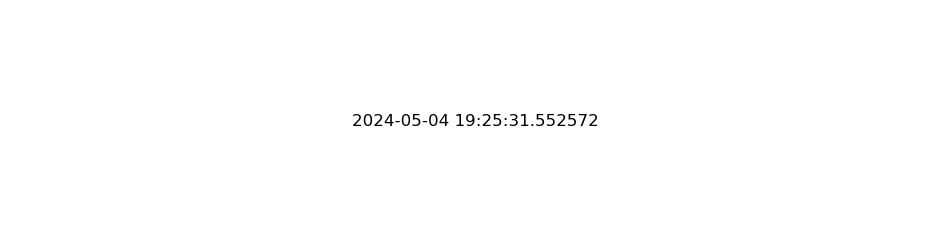

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 3))

ax.text(0.5, 0.5, pd.Timestamp.now(), fontsize=12, ha='center')

ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([])
ax.set_yticks([])

plt.savefig('current_period.png')

plt.show()